In [7]:
from commonfunctions import  *

In [8]:
# def any2gray(img: np.ndarray) -> np.ndarray:
#     image = img.copy()
#     if len(image.shape) > 3:
#         image = image[:, :, 0:3, 0]
#     if len(image.shape) == 2:
#         return image
#     elif len(image.shape) == 3:
#         if image.shape[2] == 3:
#             return rgb2gray(image)
#         elif image.shape[2] == 4:
#             return rgb2gray(rgba2rgb(image))
#     else:
#         raise Exception("Invalid image shape")

# def change_gray_range(image: np.ndarray, format: int = 255) -> np.ndarray:
#     if format == 255 and np.max(image) > 1:
#         return image
#     elif format == 1 and np.max(image) <= 1:
#         return image
#     if format == 255:
#         return (image*255).astype(np.uint8)
#     elif format == 1:
#         return image/255

# def extract_features(image: np.ndarray) -> np.ndarray:
#     img = image.copy()
#     img = change_gray_range(any2gray(img), 255)

#     img = cv2.resize(img, HOG_iMAGE_SIZE)
#     win_size = HOG_iMAGE_SIZE
#     cell_size = HOG_CELL_SIZE
#     block_size_in_cells = HOG_BLOCK_SIZE
#     block_size = (block_size_in_cells[1] * cell_size[1],
#                   block_size_in_cells[0] * cell_size[0])
#     block_stride = (block_size_in_cells[1] * cell_size[1],
#                     block_size_in_cells[0] * cell_size[0])  # no overlap
#     nbins = 9
#     hog = cv2.HOGDescriptor(win_size, block_size,
#                             block_stride, cell_size, nbins)
#     h = hog.compute(img)
#     h = h.flatten()
#     return h.flatten()

# def get_data(DATASET_PATH: str):
#     features = {}
#     for folder in os.listdir(DATASET_PATH):
#         features[folder] = []
#         for file in os.listdir(os.path.join(DATASET_PATH, folder)):
#             img = io.imread(os.path.join(DATASET_PATH, folder, file), 0)
#             features[folder].append(extract_features(img))
#     return features

# def save_model(classifier, path: str):
#     pickle.dump(classifier, open(path, 'wb'))

# def load_model(path: str):
#     if not os.path.exists(path):
#         raise Exception('Model not found')
#     return pickle.load(open(path, 'rb'))

# def accuracy_score(y_test, y_pred):
#     return sum(y_test == y_pred) / len(y_test)

# def confusion_matrix(y_test, y_pred):
#     labels = np.unique(y_test)
#     confusion_matrix = np.zeros((len(labels), len(labels)))
#     for i in range(len(y_test)):
#         confusion_matrix[labels == y_test[i], labels == y_pred[i]] += 1
#     return confusion_matrix

# def svm_classifier(features: dict, kernel: str = 'rbf'):
#     x = []
#     y = []
#     random_number= np.random.seed(RANDOM_SEED)
#     for label in features.keys():
#         for feature in features[label]:
#             x.append(feature)
#             y.append(label)
#     X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=random_number)
#     classifier = svm.NuSVC(kernel=kernel, random_state=random_number)
#     print((classifier))
#     classifier.fit(X_train, y_train)
#     save_model(classifier, MODEL_NAME)
#     return classifier, X_test, y_test

# def test(classifier, X_test, y_test):
#     y_pred = classifier.predict(X_test)
#     print("Seed: ", RANDOM_SEED)
#     print("Accuracy: ", accuracy_score(y_test, y_pred))
#     print("Confusion matrix:\n ", confusion_matrix(y_test, y_pred))

In [9]:
def preprocessing(img):
    #selem = morphology.square(3)
    selem = morphology.disk(3)
    dilated_img = morphology.dilation(img, selem)

## Reading dataset

In [10]:
def readingAndConvert(img_path: str) -> np.ndarray:
    image = io.imread(img_path).astype(np.uint8)
    if len(image.shape) == 2:   
        return image
    else:
        gray_img = rgb2gray(image)
        return gray_img

def readDataset(dir: str) -> list[np.ndarray]:
    dataset = []
    read_imgs = os.listdir(dir)
    for i in range(len(read_imgs)):
        dataset.append(readingAndConvert(dir + read_imgs[i]))
    return dataset

forged_imgs = readDataset('1/forged/')
real_imgs = readDataset('1/real/')

# show_images([real_imgs[2]])
# print(len(real_imgs))


# Data augmentation 

In [11]:
# def readingAndConvert(img_path: str) -> np.ndarray:
#     image = io.imread(img_path).astype(np.uint8)
#     if len(image.shape) == 2:
#         return np.expand_dims(image, axis=-1)  
#     else:
#         gray_img = rgb2gray(image)
#         return np.expand_dims(gray_img, axis=-1) 


# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     vertical_flip=True,
#     brightness_range=[0.8, 1.2]
# )

# datagen1 = ImageDataGenerator(
#     rotation_range=45,
#     width_shift_range=0.2,
#     height_shift_range=0.6,
#     shear_range=0.3,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     vertical_flip=False,
#     brightness_range=[0.5, 0.9]
# )

# forged_imgs = os.listdir('1/forged/')
# forged_img_imgs=[]
# for i in range(len(forged_imgs)):
#     forged_img_imgs.append(readingAndConvert('1/forged/'+forged_imgs[i]))
#     img = readingAndConvert('1/forged/' + forged_imgs[i])
#     img = np.expand_dims(img, axis=0)  
#     augmented_imgs = datagen.flow(img, batch_size=1)
#     augmented_img = augmented_imgs[0][0]
#     forged_img_imgs.append(augmented_img)

#     img1 = readingAndConvert('1/forged/' + forged_imgs[i])
#     img1= np.expand_dims(img1, axis=0)  
#     augmented_imgs1 = datagen1.flow(img1, batch_size=1)
#     augmented_img1 = augmented_imgs1[0][0]
#     forged_img_imgs.append(augmented_img1)

# real_imgs = os.listdir('1/real/')
# real_img_imgs=[]
# for i in range(len(real_imgs)):
#     real_img_imgs.append(readingAndConvert('1/real/'+real_imgs[i]))
#     img = readingAndConvert('1/real/' + real_imgs[i])
#     img = np.expand_dims(img, axis=0)  
#     augmented_imgs = datagen.flow(img, batch_size=1)
#     augmented_img = augmented_imgs[0][0]
#     real_img_imgs.append(augmented_img)

#     img1 = readingAndConvert('1/real/' + real_imgs[i])
#     img1= np.expand_dims(img1, axis=0)  
#     augmented_imgs1 = datagen1.flow(img1, batch_size=1)
#     augmented_img1 = augmented_imgs1[0][0]
#     real_img_imgs.append(augmented_img1)

# test_image = readingAndConvert('./test.jpeg')

# print(len(real_img_imgs))
# show_images([test_image])

## noise removal

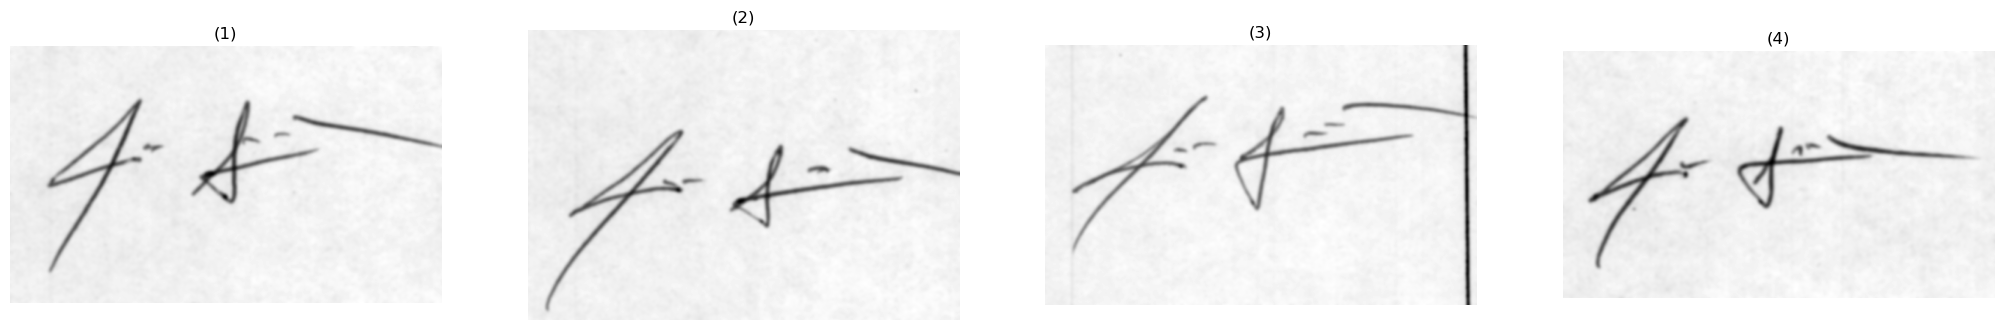

In [12]:
# removing noise using gaussian, we will try median filter on other test images

# apply median filter

# def median_filter(img,w,h):
#     edgex = math.floor(w/2)
#     edgey= math.floor(h/2)
#     img2=img.copy()
#     for x in range(edgex ,  img.shape[1] - edgex):
#         for y in range(edgey, img.shape[0] - edgey):
#             colorArray =np.zeros([w,h])
#             for fx in range(w):
#                 for fy in range(h):
#                     colorArray[fy][fx] = img[y + fy - edgey] [x + fx - edgex] 


def noiseRemoval(img: np.ndarray) -> np.ndarray:
    clean_img = gaussian(img, 2)
    return clean_img

def noiseRemovalOnDataSet(imgs: list[np.ndarray]) -> None:
    for i in range(len(imgs)):
        imgs[i] = noiseRemoval(imgs[i])

noiseRemovalOnDataSet(real_imgs)
show_images(real_imgs[:4])


## contrast enhancement

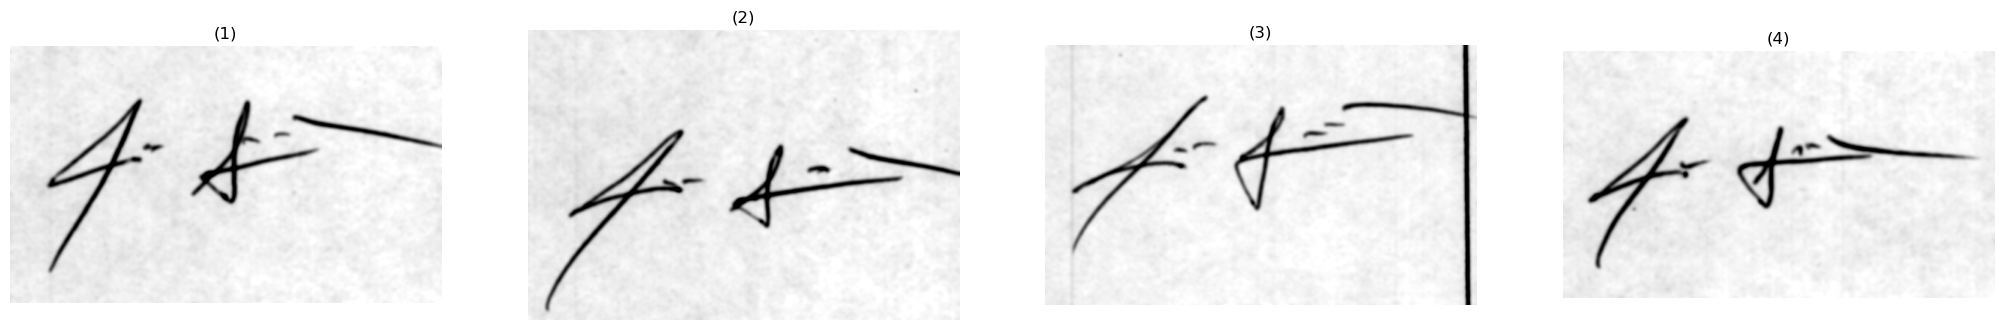

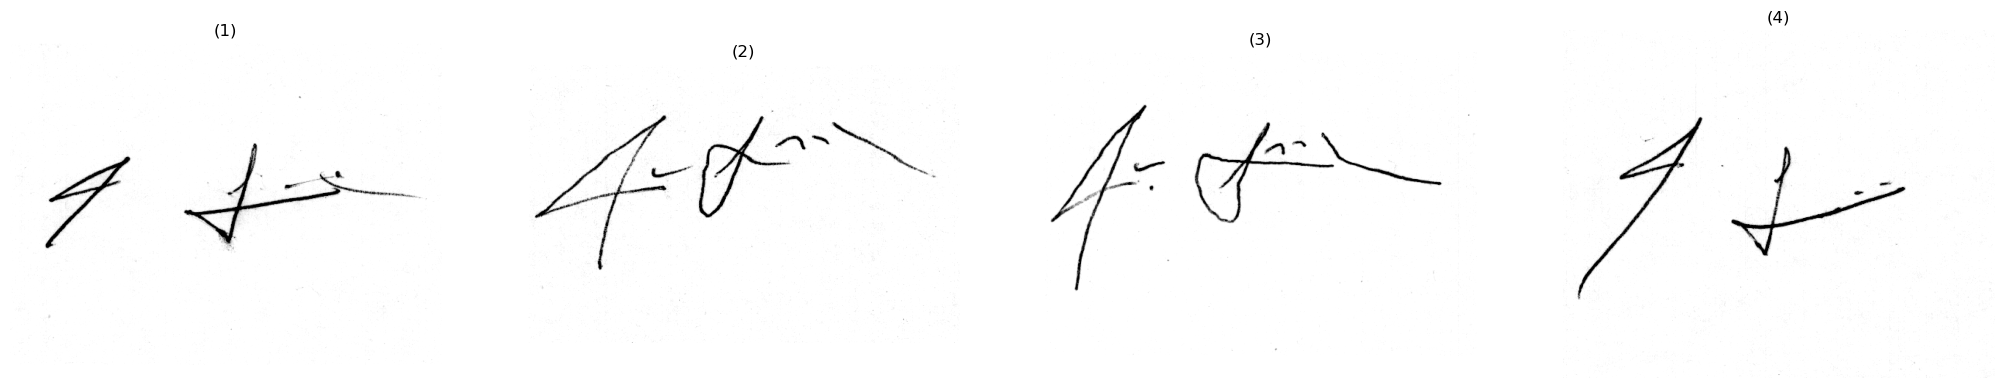

In [13]:
def contrastEnhancemet(imgs: list[np.ndarray]) -> None:
    for i in range(len(imgs)):
        low, high = np.percentile(imgs[i], [1, 99])
        imgs[i] = rescale_intensity(imgs[i], in_range=(low, high))

contrastEnhancemet(real_imgs)
contrastEnhancemet(forged_imgs)

show_images(real_imgs[:4])
show_images(forged_imgs[:4])

## binarization

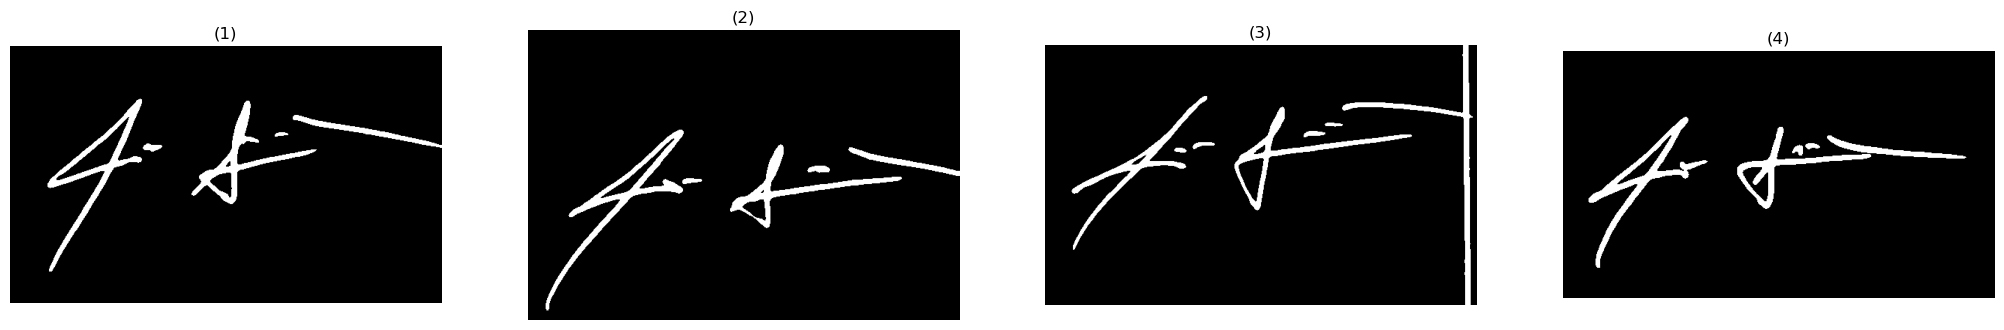

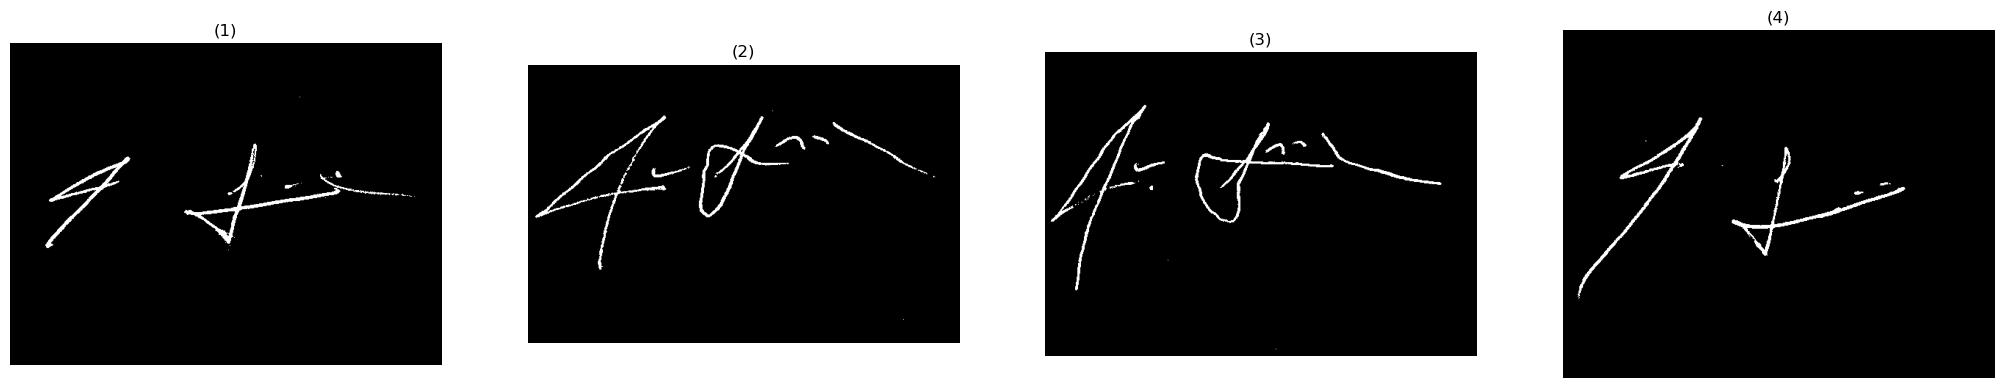

In [14]:
def binarize(imgs: list[np.ndarray]) -> None:
    binarized_imgs=[]
    for i in range(len(imgs)):
        threshold = threshold_otsu(imgs[i])
        binarized_imgs.append(imgs[i] < threshold)
        binarized_imgs[i] = binarized_imgs[i].astype(np.uint8)
    return binarized_imgs

real_imgs_binarized=binarize(real_imgs)
forged_imgs_binarized=binarize(forged_imgs)

show_images(real_imgs_binarized[:4])
show_images(forged_imgs_binarized[:4])

## skew correction

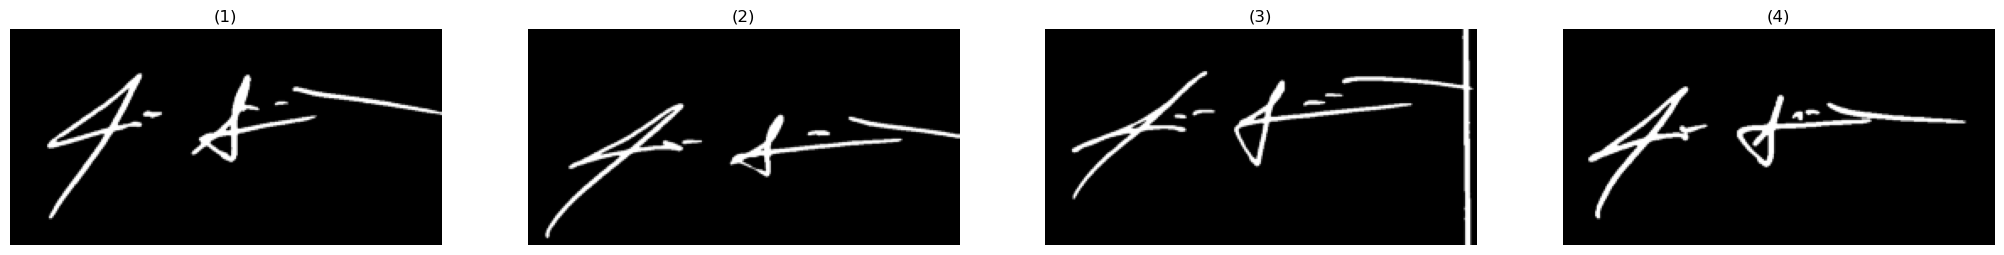

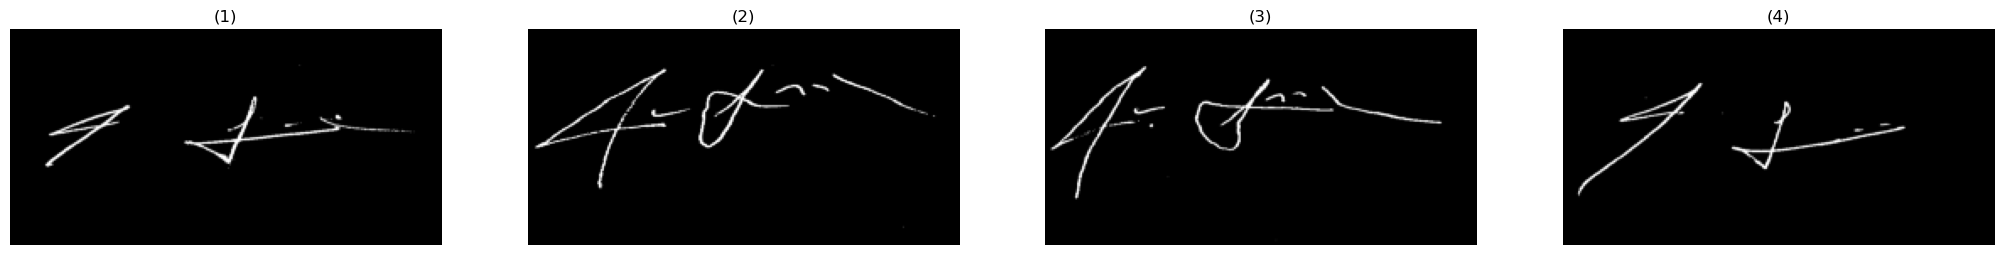

(128, 256)


In [15]:
def skewCorrection(imgs: np.ndarray) -> None:
    skew_corrected_imgs=[]
    for i in range(len(imgs)):
        skew_corrected_imgs.append(transform.resize(imgs[i], (128, 256), mode='reflect', anti_aliasing=True))
    return skew_corrected_imgs

skew_corrected_real_imgs=skewCorrection(real_imgs_binarized)
skew_corrected_forged_imgs=skewCorrection(forged_imgs_binarized)

show_images(skew_corrected_real_imgs[:4])
show_images(skew_corrected_forged_imgs[:4])

print(skew_corrected_real_imgs[0].shape)

## size normalization

## thinning/skelatanization

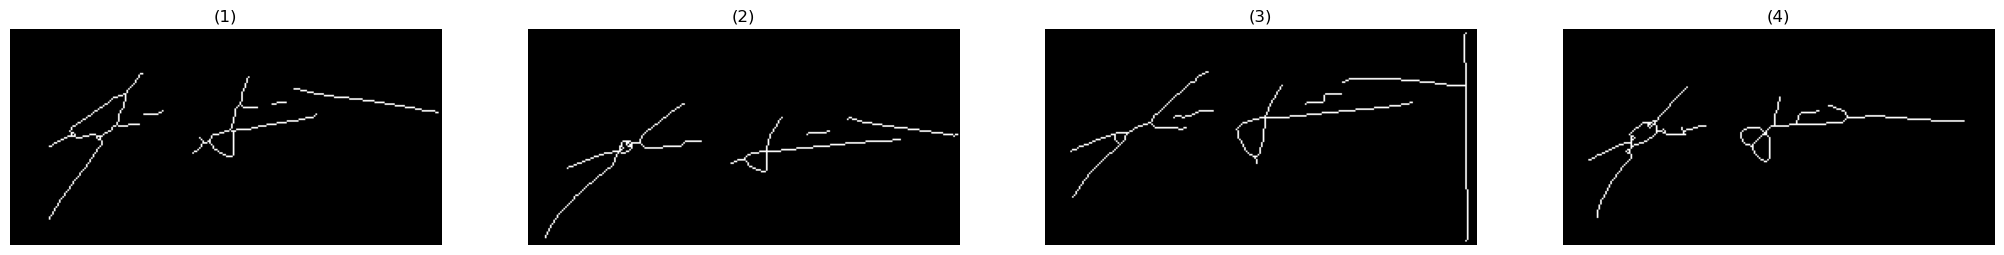

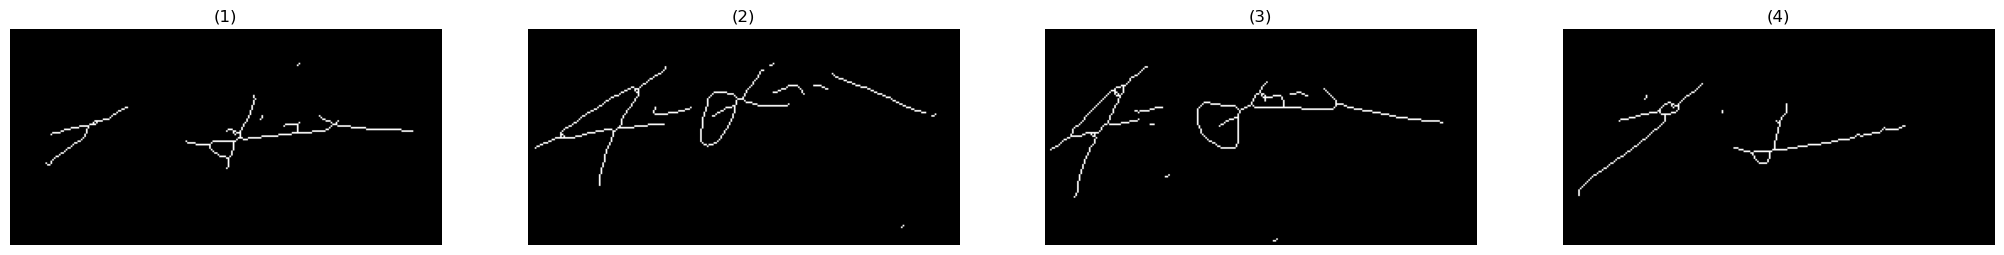

In [16]:
def skeletonization(imgs: list[np.ndarray]) -> list[np.ndarray]:
     skeletonized_imgs = []
     for i in range(len(imgs)):
        skeletonized_imgs.append(skeletonize(imgs[i]))
     return skeletonized_imgs

real_imgs_skeletonized = skeletonization(skew_corrected_real_imgs)
forged_imgs_skeletonized = skeletonization(skew_corrected_forged_imgs)

show_images(real_imgs_skeletonized[:4])
show_images(forged_imgs_skeletonized[:4])

## feature extraction

In [17]:
def HOGFeatureExtractionSkimage(image: np.ndarray) -> np.ndarray:
    image = image.astype(np.uint8)
    features = hog(image, orientations=9, pixels_per_cell=(9, 9),
    cells_per_block=(3,3), transform_sqrt=True, block_norm="L1")
    return features

def extractFeatures(imgs: list[np.ndarray]) -> list[np.ndarray]:
    extracted_features = []
    for i in range(len(imgs)):
        extracted_features.append(HOGFeatureExtractionSkimage(imgs[i]))
    return extracted_features

real_extracted_features = extractFeatures(real_imgs_skeletonized)
forged_extracted_features = extractFeatures(forged_imgs_skeletonized)


## SVM using hog

In [18]:
HOG_features = forged_extracted_features + real_extracted_features
HOG_labels_forged = [0 for _ in range(len(forged_extracted_features))]
HOG_labels_real = [1 for _ in range(len(real_extracted_features))]
HOG_labels = HOG_labels_forged + HOG_labels_real

x_train, x_test, y_train, y_test = train_test_split(HOG_features, HOG_labels, test_size = 0.2, random_state = 42)
model = svm.SVC(kernel='rbf')
model.fit(x_train, y_train)

# Test the model on images it hasn't seen before
accuracy = model.score(x_test, y_test)
print(x_test[0].shape)
print("SVM using HOG as feature descriptor.", 'accuracy:', accuracy * 100, '%')

(25272,)
SVM using HOG as feature descriptor. accuracy: 70.0 %


## KNN

In [19]:
model=KNeighborsClassifier(n_neighbors=1)
model.fit(x_train,y_train)
accuracy = model.score(x_test, y_test)
print("KNN using HOG as feature descriptor.", 'accuracy:', accuracy * 100, '%')

KNN using HOG as feature descriptor. accuracy: 100.0 %


In [20]:
features= get_data(DATASET_PATH)
classifier, X_test, y_test = svm_classifier(features)
test(load_model(MODEL_NAME), X_test, y_test)

new_signature = io.imread('test.jpeg', 0)
test_features = extract_features(new_signature)

prediction = classifier.predict(test_features.reshape(1, -1))

if prediction == 0:
    print("The signature is predicted to be genuine.")
else:
    print("The signature is predicted to be forged.")


NameError: name 'get_data' is not defined